In [ ]:
!pip install catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import re

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import lightgbm as lgb
from scipy import stats
from catboost import CatBoostClassifier, Pool, cv
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
import random

from sklearn.preprocessing import LabelEncoder



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Adrenal Dataset

In [ ]:
df = pd.read_csv('/content/Adrenal_cleaned.csv')
label = 'Readmission (Y/N):'

le = LabelEncoder()
df['Ethnicity'] = le.fit_transform(df['Ethnicity'])
df['Gender'] = le.fit_transform(df['Gender'])

cols = ['PB','Doxazosin','Spironolactone','BB','ACEI/ARB','CCB','Hydralazine','Clondine']

for col in cols:
  df[col] = df[col].fillna(0)
  df[col] = df[col].astype(str).str.replace('[^0-9]', '', regex=True).fillna(0)
  df[col] = df[col].str.replace('', '0').astype(int)

for col in df.columns:
  df[col] = df[col].astype(str).str.replace(r'[a-zA-Z<>/\\]', '', regex=True)
  df[col] = pd.to_numeric(df[col], errors='coerce')


remove_dupplicates = True #0.5 -> 0.76
feature_engineering = False #0.76 -> 0.77
weighted_loss = False




In [ ]:
df

,Gender,Age,Ethnicity,EtOH,Smoker/Former,Family Hx,CRI,HD,CVA,Hypothyroid,...,ACC,Mets,Aldosternoma.1,Hyperplasia,Cyst,Normal,Capsular disruption (Y/N),Visceral Injury (Y/N),Hemorrhage requiring transfusion (Y/N),Readmission (Y/N):
0,0,62.0,3,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,72.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,50.0,5,1.0,0.0,NaN,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,63.0,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,50.0,3,1.0,1.0,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,0,51.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
571,1,71.0,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
572,0,68.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
573,0,61.0,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


## Parathyroid/Thyroid Data

In [ ]:
# Load in dataset and choose options

df = pd.read_csv('/content/FINALNSQIP.csv')
label = 'READMISSION1'

for column in df.columns:
  if df[column].dtype == object:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Remove other labels
# outcomes = ['transient hypocalcemia(0/1) (per pt reported ssx)','Clinical concern for hypopara (1/0)','Voice hoarseness at 2wks(1/0)','ED Visit (1/0):', 'Readmission (1/0)']
# outcomes.remove(label)
# df.drop(columns=outcomes, inplace=True)
# df[['Hyperthyroidism', 'T3']] = df[['Hyperthyroidism', 'T3']].apply(pd.to_numeric, errors='coerce')


remove_dupplicates = True #0.5 -> 0.76
feature_engineering = False #0.76 -> 0.77
weighted_loss = False

In [ ]:
columns_to_remove = ['THY_CALCIUM',
    'THY_HYPOCALC30', 'THY_HYPOCALC30_UNK', 'THY_HYPOCALC_EVENT', 'THY_HYPOCALC_EVENTTYPE',
    'THY_LARYNGEAL', 'THY_NECK_HEMATOMA', 'RETURNOR', 'STILLINHOSP',
    'SUPINFEC', 'NWNDINFD', 'ORGSPCSSI', 'DEHIS', 'OUPNEUMO', 'REINTUB',
    'PULEMBOL', 'FAILWEAN', 'RENAINSF', 'OPRENAFL', 'URNINFEC', 'CNSCVA',
    'CDARREST', 'CDMI', 'OTHBLEED', 'OTHDVT', 'OTHSYSEP', 'OTHSESHOCK','REOPERATION1'
    'REOPERATION2', 'REOPERATION3',
    'READMSUSPREASON1', 'READMSUSPREASON2', 'READMSUSPREASON3',
    'READMSUSPREASON4', 'READMSUSPREASON5',
    'READMUNRELSUSP1', 'READMUNRELSUSP2', 'READMUNRELSUSP3',
    'READMUNRELSUSP4', 'READMUNRELSUSP5', 'READMISSION2', 'READMISSION3', 'READMISSION4',
    'READMISSION5', 'READMPODAYS1', 'READMPODAYS2', 'READMPODAYS3',
    'READMPODAYS4', 'READMPODAYS5',
    'UNPLANNEDREADMISSION1', 'UNPLANNEDREADMISSION2', 'UNPLANNEDREADMISSION3',
    'UNPLANNEDREADMISSION4', 'UNPLANNEDREADMISSION5',
    'READMRELATED1', 'READMRELATED2', 'READMRELATED3', 'READMRELATED4',
    'READMRELATED5'
]

# Remove the columns, ignoring any missing columns
df = df.drop(columns=columns_to_remove, errors='ignore')

# Display the updated DataFrame
df.head()

,THY_INDICATION,THY_CLINTOX,THY_NECKSURG,THY_NEEDLEBIOP,THY_OPER_APPR,THY_NECKDISSECT,THY_SCALPEL,THY_ELECTRO,THY_DRAINUSE,THY_NEOPLASM,...,PROC_UNLISTED PROCEDURE HEMIC OR LYMPHATIC SYSTEM,PROC_EXCISION THYROGLOSSAL DUCT CYST/SINUS,PROC_BX/EXC LYMPH NODE OPEN DEEP CERVICAL NODE,PROC_MUSC MYOQ/FSCQ FLAP HEAD&NECK W/NAMED VASC PEDCL,PROC_EXCISION TRACHEAL TUMOR/CARCINOMA CERVICAL,PROC_THYROIDECTOMY TOTAL/SUBTOTAL LMTD NECK DISSECT,PROC_THYROIDECTOMY RMVL REMAINING TISS FLWG PRTL RMVL,PROC_CERVICAL LYMPHADEC MODIFIED RADICAL NECK DSJ,CONCURR_BRNCHSC INCL FLUOR GDNCE DX W/CELL WASHG SPX,CONCURR_CERVICAL LYMPHADEC MODIFIED RADICAL NECK DSJ
0,9,1,0,4,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,1,0,6,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9,1,0,6,1,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
4,9,1,0,5,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.drop(columns=['CASEID','REOPERATION1'], inplace=True)

KeyError: "['CASEID', 'REOPERATION1'] not found in axis"

## Remove Excess columns

In [ ]:
# Remove data which contains more than 5 missing columns, from class 0

if remove_dupplicates == True:
  missing_threshold = 5
  df['missing_features'] = df.isnull().sum(axis=1)
  df = df[(df['missing_features'] < missing_threshold) | (df[label] != 0)]
  df = df.drop('missing_features', axis=1)
  df.dropna(subset=[df.columns[-1]], inplace=True)
df[label].value_counts()


,count
READMISSION1,
0,20961
1,468


In [ ]:
# Optional Feature Engineering

def feature_eng(df):
  if feature_engineering == False:
    return df
  else:
    df['BMI_category'] = pd.cut(df['BMI'],
                                        bins=[0, 18.5, 25, 30, np.inf],
                                        labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

    # 2. Age groups
    df['Age_group'] = pd.cut(df['Age'],
                                      bins=[0, 18, 30, 45, 60, np.inf],
                                      labels=['18', '18-30', '31-45', '46-60', '60+'])

    # 3. Calcium to PTH ratio
    df['Calcium_PTH_ratio'] = df['Calcium'] / df['PTH']

    # 4. TSH to FT4 ratio
    df['TSH_FT4_ratio'] = df['TSH'] / df['FT4']

    # 5. BP categories
    df['BP_category'] = pd.cut(df['BP'],
                                        bins=[0, 120, 130, 140, np.inf],
                                        labels=['Normal', 'Elevated', 'Stage 1', 'Stage 2'])

    # 6. Creatinine clearance (Cockcroft-Gault equation)
    df['Creat_clearance'] = ((140 - df['Age']) * df['BMI']) / (72 * df['Creat'])
    df.loc[df['Gender'] == 0, 'Creat_clearance'] *= 0.85  # Adjust for females

    # 7. TSH * FT4 interaction
    df['TSH_FT4_interaction'] = df['TSH'] * df['FT4']

    # 8. BMI to Age ratio
    df['BMI_Age_ratio'] = df['BMI'] / df['Age']

    # 9. Log transformations
    df['Log_TSH'] = np.log1p(df['TSH'])
    df['Log_PTH'] = np.log1p(df['PTH'])


    # One-hot encode BMI category
    bmi_encoded = pd.get_dummies(df['BMI_category'], prefix='BMI')
    bmi_encoded = bmi_encoded.astype(int)
    df = pd.concat([df, bmi_encoded], axis=1)
    df = df.drop('BMI_category', axis=1)

    age_encoded = pd.get_dummies(df['Age_group'], prefix='Age')
    age_encoded = age_encoded.astype(int)
    df = pd.concat([df, age_encoded], axis=1)
    df = df.drop('Age_group', axis=1)

    bp_encoded = pd.get_dummies(df['BP_category'], prefix='BP')
    bp_encoded = bp_encoded.astype(int)
    df = pd.concat([df, bp_encoded], axis=1)
    df = df.drop('BP_category', axis=1)

    return df


df_eng = feature_eng(df)

In [ ]:
# Rename variables and split

df_eng = df_eng.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


label = (lambda x: re.sub('[^A-Za-z0-9_]+', '', x))(label)
y = df_eng[label]
X = df_eng.drop([label],axis=1)


In [ ]:
X.shape

(21429, 162)

In [ ]:
# Do Grid search on models

model_to_search = 'catboost' # 'catboost' or 'lgbm' or 'xg'

if model_to_search == 'catboost':
  model = CatBoostClassifier(
    iterations=500,
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100
  )
  param_grid = {
    'depth': [1,2,3,4,5],
    'learning_rate': [0.003,0.01,0.03, 0.1],
    'l2_leaf_reg': [1,2, 3,4, 5]
  }
elif model_to_search == 'lgbm':
  model = lgb.LGBMClassifier(random_state=42, is_unbalance=weighted_loss)
  param_grid = {
    'n_estimators': [50,100, 200],
    'max_depth': [-1,1,2,3],
    'learning_rate': [0.01, 0.1, 0.3],
    'feature_fraction': [0.8,0.9,1.0],
    'bagging_fraction': [0.8,0.9,1.0],
  }
elif model_to_search == 'xg':
  model = XGBClassifier(random_state=42)
  param_grid = {
    'n_estimators': [50,100, 200],
    'max_depth': [-1,1,2,3],
    'learning_rate': [0.01, 0.1, 0.3],
  }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='roc_auc')
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)


Streaming output truncated to the last 5000 lines.
499:	total: 3.43s	remaining: 0us
0:	total: 9.67ms	remaining: 4.83s
100:	total: 687ms	remaining: 2.71s
200:	total: 1.72s	remaining: 2.56s
300:	total: 3.27s	remaining: 2.16s
400:	total: 4.81s	remaining: 1.19s
499:	total: 5.53s	remaining: 0us
0:	total: 7.11ms	remaining: 3.54s
100:	total: 740ms	remaining: 2.92s
200:	total: 1.45s	remaining: 2.16s
300:	total: 2.19s	remaining: 1.45s
400:	total: 2.92s	remaining: 721ms
499:	total: 3.65s	remaining: 0us
0:	total: 7.02ms	remaining: 3.5s
100:	total: 729ms	remaining: 2.88s
200:	total: 1.45s	remaining: 2.16s
300:	total: 2.2s	remaining: 1.45s
400:	total: 2.96s	remaining: 730ms
499:	total: 3.67s	remaining: 0us
0:	total: 7.42ms	remaining: 3.71s
100:	total: 714ms	remaining: 2.82s
200:	total: 1.99s	remaining: 2.96s
300:	total: 3.61s	remaining: 2.39s
400:	total: 4.81s	remaining: 1.19s
499:	total: 5.5s	remaining: 0us
0:	total: 6.52ms	remaining: 3.25s
100:	total: 689ms	remaining: 2.72s
200:	total: 1.36s	rema

In [ ]:
# Define models for comparison

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)

lr = LogisticRegression(random_state=42)

lgbm = lgb.LGBMClassifier(random_state=42, bagging_fraction=0.8, feature_fraction= 0.8, learning_rate=0.3, max_depth= 3, n_estimators=100, is_unbalance=weighted_loss)
cat = CatBoostClassifier(iterations=1000,
                               learning_rate=0.01,
                               depth=4,
                               l2_leaf_reg=3,
                               loss_function='Logloss',
                               eval_metric='AUC',
                               early_stopping_rounds=50,
                               random_seed=42,
                               verbose=100,
                               class_weights=[0.15,0.85] if weighted_loss else [0.5, 0.5])
xg = XGBClassifier(random_state=42)

# If you did grid serach
# lgbm = best_model
# cat = best_model
# xg = best_model




In [ ]:
# Calculate metrics

# Perform 5-fold cross-validation
def evaluate_model(model, X_train, y_train, X_val, y_val, needs_imputation=False):
    """Trains and evaluates a given model."""
    if needs_imputation:
        imputer = SimpleImputer(strategy='median')
        X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
        X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)

    model.fit(X_train, y_train)
    pred_proba = model.predict_proba(X_val)[:, 1]
    pred = model.predict(X_val)
    return pred_proba, pred


models = {
    "LGBM": lgbm,
    "CatBoost": cat,
    "XGBoost": xg,
    "Logistic Regression": lr,
}

metrics = ['auc', 'balanced_accuracy', 'accuracy', 'precision', 'recall', 'f1']
model_scores = {model_name: {metric: [] for metric in metrics} for model_name in models}

for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    for model_name, model in models.items():
        needs_imputation = model_name == "Logistic Regression"
        pred_proba, pred = evaluate_model(model, X_train, y_train, X_val, y_val, needs_imputation)

        for metric in metrics:
            if metric == 'auc':
                score = roc_auc_score(y_val, pred_proba)
            elif metric == 'balanced_accuracy':
                score = balanced_accuracy_score(y_val, pred)
            elif metric == 'accuracy':
                score = accuracy_score(y_val, pred)
            elif metric == 'precision':
                score = precision_score(y_val, pred)
            elif metric == 'recall':
                score = recall_score(y_val, pred)
            elif metric == 'f1':
                score = f1_score(y_val, pred)
            model_scores[model_name][metric].append(score)

    print(f"Fold {fold} completed")

# Calculate average scores and confidence intervals
def calculate_and_print_results(scores, models, metrics):
    """Calculates average scores and confidence intervals for each model and metric."""
    for metric in metrics:
        print(f"\n{metric.upper()}:")
        for model_name in models:
            avg_score = np.mean(scores[model_name][metric])
            ci = stats.t.interval(confidence=0.95, df=len(scores[model_name][metric])-1, loc=avg_score, scale=stats.sem(scores[model_name][metric]))
            print(f"  {model_name}: {avg_score:.4f}, 95% CI: {ci}")

calculate_and_print_results(model_scores, models, metrics)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5 completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6 completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 7 completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 8 completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 9 completed
Fold 10 completed

AUC:
  Logistic Regression: 0.6198, 95% CI: (0.5894955625699292, 0.6500459435266162)

BALANCED_ACCURACY:
  Logistic Regression: 0.5000, 95% CI: (nan, nan)

ACCURACY:
  Logistic Regression: 0.9782, 95% CI: (0.9780212077662002, 0.9782996998159957)

PRECISION:
  Logistic Regression: 0.0000, 95% CI: (nan, nan)

RECALL:
  Logistic Regression: 0.0000, 95% CI: (nan, nan)

F1:
  Logistic Regression: 0.0000, 95% CI: (nan, nan)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local

In [ ]:
# prompt: get adjusted odds ratio from the [reviously run logistic regression

import statsmodels.api as sm

# Assuming 'lr' is your fitted Logistic Regression model from sklearn
# Get the coefficients and intercept
coefficients = lr.coef_[0]
intercept = lr.intercept_[0]

# Create a DataFrame with feature names and coefficients
coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': coefficients})

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y, sm.add_constant(X))
result = logit_model.fit()

# Get the adjusted odds ratios and their confidence intervals
odds_ratios = np.exp(result.params)
confidence_intervals = np.exp(result.conf_int())

# Create a DataFrame for adjusted odds ratios
odds_ratio_df = pd.DataFrame({'Odds Ratio': odds_ratios,
                              'Lower CI': confidence_intervals[0],
                              'Upper CI': confidence_intervals[1]},
                             index=result.params.index)

# Display the adjusted odds ratios
print(odds_ratio_df)



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix

0:	total: 10.4ms	remaining: 5.17s
100:	total: 1.07s	remaining: 4.25s
200:	total: 2.15s	remaining: 3.19s
300:	total: 3.2s	remaining: 2.12s
400:	total: 4.95s	remaining: 1.22s
499:	total: 7.23s	remaining: 0us


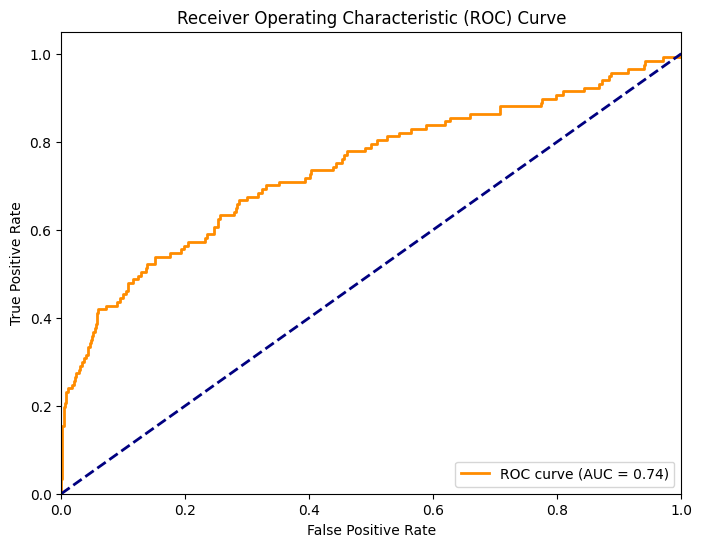

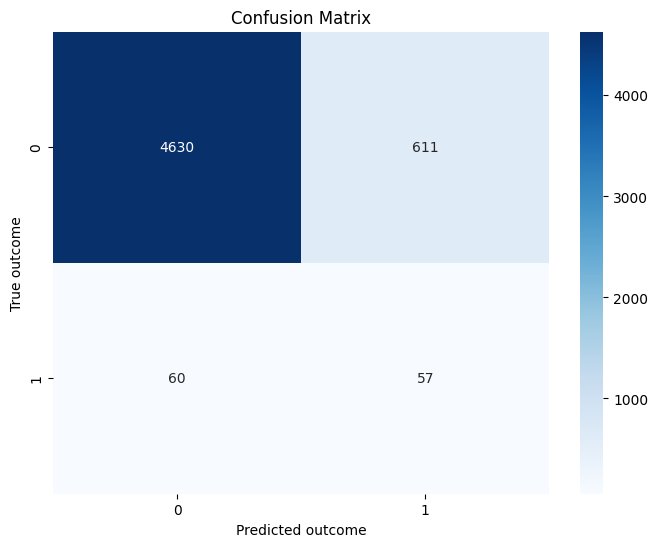


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      5241
           1       0.09      0.49      0.15       117

    accuracy                           0.87      5358
   macro avg       0.54      0.69      0.54      5358
weighted avg       0.97      0.87      0.92      5358


Additional Metrics:
Accuracy: 0.8748
Balanced Accuracy: 0.6853
Precision: 0.0853
Recall: 0.4872
F1 Score: 0.1452
AUC-ROC: 0.7385


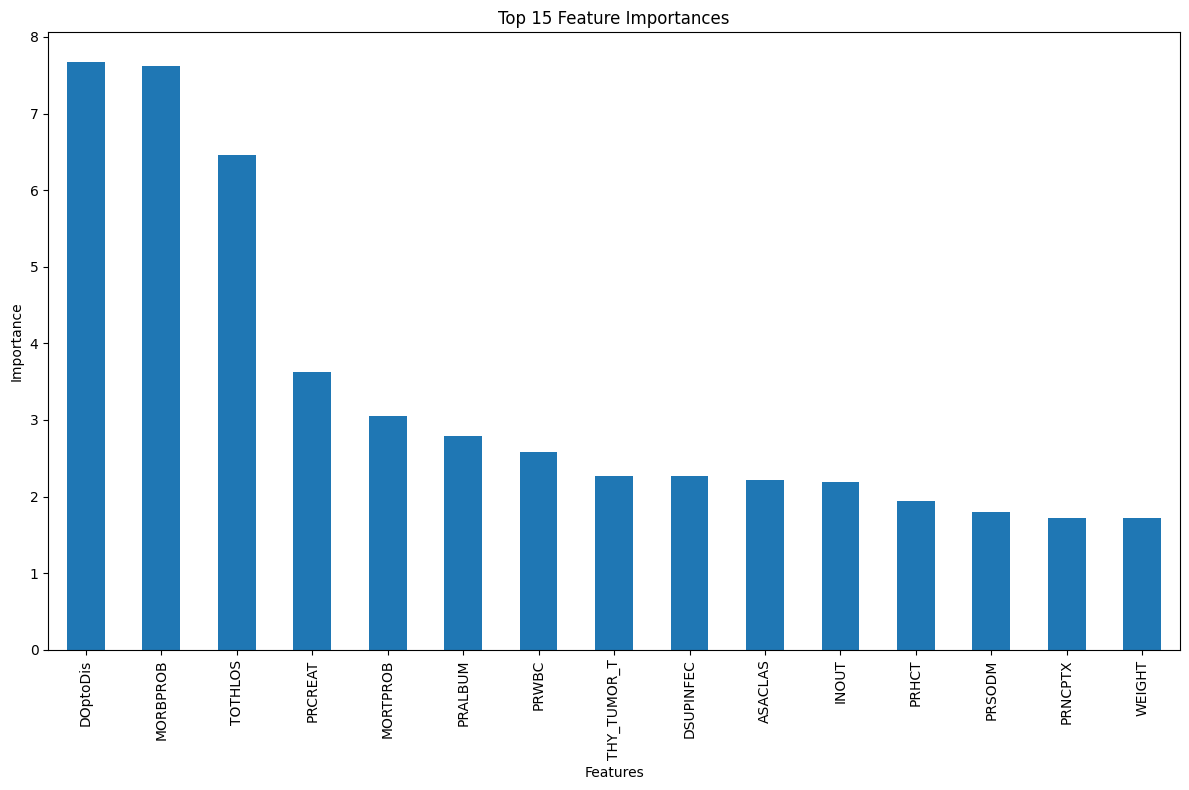


Top 15 Feature Importances:
DOptoDis                                           7.675601
MORBPROB                                           7.616931
TOTHLOS                                            6.460003
PRCREAT                                            3.626508
MORTPROB                                           3.045993
                                                     ...   
PROC_DISSECTIONDEEPJUGULARNODE                     0.000000
PROC_PRTLTHYROIDLOBECTOMYUNIWWOISTHMUSECTOMY       0.000000
PROC_NEEDLEELECTROMYOGRAPHYLARYNX                  0.000000
PROC_EXPLPOHEMRRGTHROMBOSISINFCTJNCK               0.000000
CONCURR_CERVICALLYMPHADECMODIFIEDRADICALNECKDSJ    0.000000
Length: 162, dtype: float64


In [ ]:
3# Test other metrics for one split of the data

model = cat # xg/cat/lgbm

train_df, test_df = train_test_split(df_eng, test_size=0.25, random_state=67, stratify=df_eng[label])
train_X = train_df.drop([label],axis=1)
train_y = train_df[label]
test_X = test_df.drop([label],axis=1)
test_y = test_df[label]

model.fit(train_X, train_y)

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(test_X)
y_pred_proba = model.predict_proba(test_X)[:, 1]
y_pred = (y_pred_proba > 0.03).astype('float')

# Calculate AUC-ROC
fpr, tpr, _ = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True outcome')
plt.xlabel('Predicted outcome')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_y, y_pred))

# Additional Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_y, y_pred)
balanced_acc = balanced_accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Feature Importance
feature_importance = model.feature_importances_
feature_importance = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_importance[:15].plot(kind='bar')
plt.title('Top 15 Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 15 Feature Importances:")
print(feature_importance)

In [ ]:
test_y.to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
model = cat #cat/lgbm/xg

def calculate_ci(scores):
    mean = np.mean(scores)
    ci_lower, ci_upper = stats.t.interval(confidence=0.95, df=len(scores)-1,
                                          loc=mean,
                                          scale=stats.sem(scores))
    return mean, ci_lower, ci_upper

all_iteration_scores = []
all_iteration_cis = []

for i in range(30):
    random_state = random.randint(1, 100)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    iteration_scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        lgbm_pred_proba = model.predict_proba(X_val)[:, 1]

        fold_score = roc_auc_score(y_val, lgbm_pred_proba)
        iteration_scores.append(fold_score)

    all_iteration_scores.append(iteration_scores)
    mean_auc, ci_lower, ci_upper = calculate_ci(iteration_scores)
    all_iteration_cis.append((mean_auc, ci_lower, ci_upper))

# Calculate overall statistics
overall_mean = np.mean([ci[0] for ci in all_iteration_cis])
overall_ci_lower = np.mean([ci[1] for ci in all_iteration_cis])
overall_ci_upper = np.mean([ci[2] for ci in all_iteration_cis])

print(f"Average AUC across all iterations: {overall_mean:.4f}")
print(f"Average 95% CI across all iterations: ({overall_ci_lower:.4f}, {overall_ci_upper:.4f})")



0:	total: 12.1ms	remaining: 6.04s
100:	total: 1.14s	remaining: 4.5s
200:	total: 2.25s	remaining: 3.35s
300:	total: 3.37s	remaining: 2.23s
400:	total: 4.54s	remaining: 1.12s
499:	total: 5.66s	remaining: 0us
0:	total: 13.3ms	remaining: 6.66s
100:	total: 1.09s	remaining: 4.32s
200:	total: 2.21s	remaining: 3.28s
300:	total: 4.28s	remaining: 2.83s
400:	total: 6.31s	remaining: 1.56s
499:	total: 7.41s	remaining: 0us
0:	total: 13.7ms	remaining: 6.84s
100:	total: 1.1s	remaining: 4.37s
200:	total: 2.22s	remaining: 3.31s
300:	total: 3.38s	remaining: 2.23s
400:	total: 4.52s	remaining: 1.12s
499:	total: 5.63s	remaining: 0us
0:	total: 15ms	remaining: 7.5s
100:	total: 1.1s	remaining: 4.33s
200:	total: 2.24s	remaining: 3.34s
300:	total: 4.53s	remaining: 2.99s
400:	total: 6.42s	remaining: 1.58s
499:	total: 7.55s	remaining: 0us
0:	total: 13.5ms	remaining: 6.75s
100:	total: 1.12s	remaining: 4.42s
200:	total: 2.25s	remaining: 3.34s
300:	total: 3.36s	remaining: 2.22s
400:	total: 4.46s	remaining: 1.1s
499:	

In [ ]:
feature_importance[:25]

,0
DOptoDis,7.675601
MORBPROB,7.616931
TOTHLOS,6.460003
PRCREAT,3.626508
MORTPROB,3.045993
PRALBUM,2.787038
PRWBC,2.579350
THY_TUMOR_T,2.264429
DSUPINFEC,2.262608
ASACLAS,2.212986


In [ ]:
df2 = pd.read_csv('/content/Parafin1.csv')
label = 'Readmission'

for column in df2.columns:
  if df2[column].dtype == object:
    df2[column] = pd.to_numeric(df2[column], errors='coerce')

df2

In [ ]:
# prompt: from df2, select all the rows which have more than 2 missing values and also belong to label 0

missing_threshold = 1
df2['missing_features'] = df2.isnull().sum(axis=1)
df_selected = df2[(df2['missing_features'] > missing_threshold) & (df2[label] == 0)]
df_selected = df_selected.drop('missing_features', axis=1)
df_selected


In [ ]:
df_selected = df_selected.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


label = (lambda x: re.sub('[^A-Za-z0-9_]+', '', x))(label)
y = df_selected[label]
X = df_selected.drop([label],axis=1)

In [ ]:
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)[:, 1]
y_pred = (y_pred_proba > 0.5).astype('float')

accuracy = accuracy_score(y, y_pred)
balanced_acc = balanced_accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

In [ ]:
postives = [i for i in y_pred if i > 0.5]
len(postives)